In [18]:
import torch
import torchvision
# from torch.utils.tensorboard import SummaryWriter
import time
from torch import nn
from torch.utils.data import DataLoader
from load_data import MyData  # self-made
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm # View procedure
import os
import scipy.io
from random import random
import numpy as np
import gc
from torch.utils.tensorboard import SummaryWriter
from network_cnn_lstm import MyNetwork
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Load Test Data

In [28]:
# exper_dir = "rest"
exper_dir = "conditionC"
root_dir = f"../data/eegmap_split/{exper_dir}"
test_data = []
test_label = []
# ---- hc
dataset = MyData(root_dir, f"test", "hc") # hc
# find the fold file
for person in range(len(dataset)):
    filename = os.path.join(dataset.path, dataset.file_path[person])
    data_map = torch.load(filename)
    print(f"data_map size: {data_map.size()}")
    # extract the pure name of the file
    parts = filename.split("\\")
    file_name = parts[-1]
    name_without_extension = file_name.split(".")[0]
    # label or data
    file_last = name_without_extension.split("_")[-1]
    if file_last == "label": # label
        for label in data_map:
            test_label.append(label)
    else: # data
        for data in data_map:
            test_data.append(data)
    del filename, parts, name_without_extension, file_last
    gc.collect()
    torch.cuda.empty_cache()   
# ---- mcs
dataset = MyData(root_dir, "test", "mcs") 
# find the fold file
for person in range(len(dataset)):
    filename = os.path.join(dataset.path, dataset.file_path[person])
    data_map = torch.load(filename)
    print(f"data_map size: {data_map.size()}")
    # extract the pure name of the file
    parts = filename.split("\\")
    file_name = parts[-1]
    name_without_extension = file_name.split(".")[0]
    # label or data
    file_last = name_without_extension.split("_")[-1]
    if file_last == "label": # label
        for label in data_map:
            test_label.append(label)
    else: # data
        for data in data_map:
            test_data.append(data)
    del filename, parts, name_without_extension, file_last
    gc.collect()
    torch.cuda.empty_cache()  
# ---- uws
dataset = MyData(root_dir, "test", "uws") # uws
# find the fold file
for person in range(len(dataset)):
    filename = os.path.join(dataset.path, dataset.file_path[person])
    data_map = torch.load(filename)
    print(f"data_map size: {data_map.size()}")
    # extract the pure name of the file
    parts = filename.split("\\")
    file_name = parts[-1]
    name_without_extension = file_name.split(".")[0]
    # label or data
    file_last = name_without_extension.split("_")[-1]
    if file_last == "label": # label
        for label in data_map:
            test_label.append(label)
    else: # data
        for data in data_map:
            test_data.append(data)
    del filename, parts, name_without_extension, file_last
    gc.collect()
    torch.cuda.empty_cache()  
test_data = torch.stack(test_data)
test_label = torch.stack(test_label)
print(test_data.size())
print(test_label.size())
test_data_size = test_label.size()

data_map size: torch.Size([123, 2400, 10, 11])
data_map size: torch.Size([123])
data_map size: torch.Size([135, 2400, 10, 11])
data_map size: torch.Size([135])
data_map size: torch.Size([122, 2400, 10, 11])
data_map size: torch.Size([122])
torch.Size([380, 2400, 10, 11])
torch.Size([380])


# Hyperparameters

In [29]:
BATCH_SIZE = 1
C,H,W = 1,1,2400
learn_rate = 0.001
num_epochs = 100

In [30]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# test dataset
test_td = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_td, batch_size = BATCH_SIZE, shuffle = True)

In [31]:
del test_data
del test_label
del test_td
gc.collect()
torch.cuda.empty_cache()

# Ensuring deterministicity through Random seeding

In [32]:
import random
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
manualSeed = 4
random.seed(manualSeed)
torch.manual_seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(manualSeed)

# Load Model

In [37]:
import torch.optim as optim
device = torch.device("cuda:0")
gc.collect()
torch.cuda.empty_cache()
# 加载预训练模型!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# 定义LSTM超参数
input_size = 64  # 输入特征维度
hidden_size = 64  # 隐藏单元数量
num_layers = 2  # LSTM层数
output_size = 2  # 输出类别数量

# ==损失函数权重
# ======== 二分类-HC/DOC
# 计算总样本数量
# condition1
# total_samples = 887 + 985 + 879
# condition2
# total_samples = 929 + 1029 + 886
# condition3
total_samples = 887 + 975 + 879
# 计算每个类别的权重
# condition1
# weights = [total_samples / 887, total_samples / (985 + 879)]
# condition2
# weights = [total_samples / 929, total_samples / (1029 + 886)]
# condition3
weights = [total_samples / 887, total_samples / (975 + 879)]
# # ======== 三分类
# # 计算总样本数量
# # conditionB
# total_samples = 929 + 1029 + 886
# # 计算每个类别的权重
# # conditionB
# weights = [total_samples / 929, total_samples / 1029, total_samples / 886]

# 将权重转换为张量
weights_tensor = torch.tensor(weights, device=device)

# 定义交叉熵损失函数并设置权重
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
# criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
fold = 4
begin = 0
end = 66
for i in tqdm(range(begin,end)):
    model = MyNetwork(input_size, hidden_size, num_layers, output_size)
    model.load_state_dict(torch.load(f"../model/hc_doc/{exper_dir}/Fold{fold}_Epoch{i}.pt"))
    model = model.to(device)

    # 测试步骤开始
    model.eval()
    # 初始化损失和准确率
    total_test_loss = 0
    total_acc_hc = 0
    total_acc_mcs = 0
    total_acc_uws = 0
    total_accuracy = 0
    # 计数
    test_count = 0
    hc_count = 0
    mcs_count = 0
    uws_count = 0
    # 用于绘制混淆矩阵
    predict_labels = torch.tensor([])
    predict_labels = predict_labels.to(device)
    true_labels = torch.tensor([])
    true_labels = true_labels.to(device)
    with torch.no_grad(): # 设置不进行后向传播
        for data in test_loader:
            test_count = test_count + 1
            data_map, label=data # x,y
            # x
            data_map_reshaped = torch.reshape(data_map, (110, 1, 1, 2400))
            data_map_reshaped = data_map_reshaped.to(device)
            # y
            label_int = label.long()
            label_int = label_int.to(device)
            # clear gpu
            del data_map
            del label
            gc.collect()
            torch.cuda.empty_cache()
            # y_pred
            label_pred_test = model(data_map_reshaped)

            # confusion matrix
            predict_labels = torch.cat((predict_labels, label_pred_test.argmax(1)), dim=0)
            true_labels = torch.cat((true_labels, label_int), dim=0)
    #         print(predict_labels)
    #         print(true_labels)
    #         predict_labels = torch.tensor([predict_labels,label_pred_test.argmax(1)[0]])
    #         true_labels = torch.tensor([true_labels,label_int])

            # loss
            loss = criterion(label_pred_test,label_int)
            total_test_loss = total_test_loss + loss.item()
            accuracy = ((label_pred_test.argmax(1)) == label_int).sum()
            if label_int == 0:
                total_acc_hc = total_acc_hc + accuracy
                hc_count = hc_count + 1
            elif label_int == 1:
                total_acc_mcs = total_acc_mcs + accuracy
                mcs_count = mcs_count + 1
            elif label_int == 2:
                total_acc_uws = total_acc_uws + accuracy
                uws_count = uws_count + 1
#             if test_count % 100 == 0:
#                 print(f"共{test_count}组，准确{total_acc_hc+total_acc_mcs+total_acc_uws}个")
#                 print(f"    HC:{total_acc_hc}个, MCS:{total_acc_mcs}个，UWS:{total_acc_uws}个")
#                 print(f"准确率:{(total_acc_hc+total_acc_mcs+total_acc_uws) / test_count}")
#                 print(f"    HC:{total_acc_hc/hc_count}, MCS:{total_acc_mcs/mcs_count}，UWS:{total_acc_uws/uws_count}")
#     print(f"共{test_count}组，准确{total_acc_hc+total_acc_mcs+total_acc_uws}个")
#     print(f"    HC:{total_acc_hc}个, MCS:{total_acc_mcs}个，UWS:{total_acc_uws}个")
    print(f"Epoch {i} == Loss:{total_test_loss} == Accuracy:{(total_acc_hc+total_acc_mcs+total_acc_uws) / test_count}")
    del model
    gc.collect()
    torch.cuda.empty_cache()
#     print(f"整体测试集上的Loss: {total_test_loss}")
#     print(f"整体测试集上的准确率: {(total_acc_hc+total_acc_mcs+total_acc_uws) / test_count}")
#     print(f"hc准确率: {total_acc_hc / hc_count}")
#     print(f"mcs准确率: {total_acc_mcs / mcs_count}")
#     print(f"uws准确率: {total_acc_uws / uws_count}")
    # writer.add_scalar("test_loss", total_test_loss, total_test_step)
    # writer.add_scalar("test_accuracy", total_accuracy / test_data_size, total_test_step)
    # total_test_step = total_test_step + 1

D:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/66 [00:00<?, ?it/s]

Epoch 0 == Loss:188.28136830031872 == Accuracy:0.7210526466369629
Epoch 1 == Loss:195.97980684041977 == Accuracy:0.7315790057182312
Epoch 2 == Loss:203.0951280593872 == Accuracy:0.7421053051948547
Epoch 3 == Loss:154.68102085217834 == Accuracy:0.8421052694320679
Epoch 4 == Loss:57.240309327840805 == Accuracy:0.9315789937973022
Epoch 5 == Loss:97.1796238356037 == Accuracy:0.9078947901725769
Epoch 6 == Loss:104.13697498428519 == Accuracy:0.9078947901725769
Epoch 7 == Loss:91.41538896714337 == Accuracy:0.936842143535614
Epoch 8 == Loss:54.048823503544554 == Accuracy:0.9473684430122375
Epoch 9 == Loss:60.20170302016777 == Accuracy:0.9210526943206787
Epoch 10 == Loss:31.488259225261572 == Accuracy:0.9710526466369629
Epoch 11 == Loss:47.326225097931456 == Accuracy:0.9605263471603394
Epoch 12 == Loss:19.119243070381344 == Accuracy:0.9842105507850647
Epoch 13 == Loss:48.424981949116045 == Accuracy:0.9684211015701294
Epoch 14 == Loss:61.528444454289456 == Accuracy:0.9657894968986511
Epoch 15 ==

# Single Test

In [29]:
import torch.optim as optim
device = torch.device("cuda:0")
gc.collect()
torch.cuda.empty_cache()

# 加载预训练模型!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# 定义LSTM超参数
input_size = 64  # 输入特征维度
hidden_size = 64  # 隐藏单元数量
num_layers = 2  # LSTM层数
output_size = 3  # 输出类别数量
model = MyNetwork(input_size, hidden_size, num_layers, output_size)

# ConditionA
model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold2_Epoch20.pt")) 
# ConditionB
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold3_Epoch19.pt")) 
model = model.to(device)

# # 计算总样本数量
# # conditionB
total_samples = 929 + 1029 + 886
# # conditionC
# total_samples = 1108 + 1218 + 1098

# # 计算每个类别的权重
# # conditionB
weights = [total_samples / 929, total_samples / 1029, total_samples / 886]
# # conditionC
# weights = [total_samples / 1108, total_samples / 1218, total_samples / 1098]

# # 将权重转换为张量
weights_tensor = torch.tensor(weights, device=device)

# # 定义交叉熵损失函数并设置权重
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
# criterion = nn.CrossEntropyLoss()
# criterion = nn.SmoothL1Loss()
criterion = criterion.to(device)


# 测试步骤开始
model.eval()
# 初始化损失和准确率
total_test_loss = 0
total_acc_hc = 0
total_acc_mcs = 0
total_acc_uws = 0
total_accuracy = 0
# 计数
test_count = 0
hc_count = 0
mcs_count = 0
uws_count = 0
# 用于绘制混淆矩阵
predict_labels = torch.tensor([])
predict_labels = predict_labels.to(device)
true_labels = torch.tensor([])
true_labels = true_labels.to(device)
with torch.no_grad(): # 设置不进行后向传播
    for data in test_loader:
        test_count = test_count + 1
        data_map, label=data # x,y
        # x
        data_map_reshaped = torch.reshape(data_map, (110, 1, 1, 2400))
        data_map_reshaped = data_map_reshaped.to(device)
        # y
        label_int = label.long()
        label_int = label_int.to(device)
        # clear gpu
        del data_map
        del label
        gc.collect()
        torch.cuda.empty_cache()
        # y_pred
        label_pred_test = model(data_map_reshaped)

        # confusion matrix
        predict_labels = torch.cat((predict_labels, label_pred_test.argmax(1)), dim=0)
        true_labels = torch.cat((true_labels, label_int), dim=0)
#         print(predict_labels)
#         print(true_labels)
#         predict_labels = torch.tensor([predict_labels,label_pred_test.argmax(1)[0]])
#         true_labels = torch.tensor([true_labels,label_int])

        # loss
        loss = criterion(label_pred_test,label_int)
        total_test_loss = total_test_loss + loss.item()
        accuracy = ((label_pred_test.argmax(1)) == label_int).sum()
        if label_int == 0:
            total_acc_hc = total_acc_hc + accuracy
            hc_count = hc_count + 1
        elif label_int == 1:
            total_acc_mcs = total_acc_mcs + accuracy
            mcs_count = mcs_count + 1
        elif label_int == 2:
            total_acc_uws = total_acc_uws + accuracy
            uws_count = uws_count + 1
        if test_count % 20 == 0:
            print(f"共{test_count}组，准确{total_acc_hc+total_acc_mcs+total_acc_uws}个")
            print(f"    HC:{total_acc_hc}个, MCS:{total_acc_mcs}个，UWS:{total_acc_uws}个")
            print(f"准确率:{(total_acc_hc+total_acc_mcs+total_acc_uws) / test_count}")
            print(f"    HC:{total_acc_hc/hc_count}, MCS:{total_acc_mcs/mcs_count}，UWS:{total_acc_uws/uws_count}")
    print(f"共{test_count}组，准确{total_acc_hc+total_acc_mcs+total_acc_uws}个")
    print(f"    HC:{total_acc_hc}个, MCS:{total_acc_mcs}个，UWS:{total_acc_uws}个")

    del model
    gc.collect()
    torch.cuda.empty_cache()
    print(f"整体测试集上的Loss: {total_test_loss}")
    print(f"整体测试集上的准确率: {(total_acc_hc+total_acc_mcs+total_acc_uws) / test_count}")
    print(f"hc准确率: {total_acc_hc / hc_count}")
    print(f"mcs准确率: {total_acc_mcs / mcs_count}")
    print(f"uws准确率: {total_acc_uws / uws_count}")
    # writer.add_scalar("test_loss", total_test_loss, total_test_step)
    # writer.add_scalar("test_accuracy", total_accuracy / test_data_size, total_test_step)
    # total_test_step = total_test_step + 1

共20组，准确18个
    HC:6个, MCS:6个，UWS:6个
准确率:0.9000000357627869
    HC:1.0, MCS:1.0，UWS:0.75
共40组，准确37个
    HC:10个, MCS:15个，UWS:12个
准确率:0.925000011920929
    HC:1.0, MCS:1.0，UWS:0.8000000715255737
共60组，准确56个
    HC:17个, MCS:24个，UWS:15个
准确率:0.9333333969116211
    HC:0.944444477558136, MCS:1.0，UWS:0.8333333134651184
共80组，准确74个
    HC:28个, MCS:29个，UWS:17个
准确率:0.925000011920929
    HC:0.9655172228813171, MCS:1.0，UWS:0.7727273106575012
共100组，准确94个
    HC:33个, MCS:39个，UWS:22个
准确率:0.9399999976158142
    HC:0.9705882668495178, MCS:1.0，UWS:0.8148148059844971
共120组，准确114个
    HC:39个, MCS:46个，UWS:29个
准确率:0.9500000476837158
    HC:0.9750000238418579, MCS:1.0，UWS:0.8529411554336548
共140组，准确134个
    HC:47个, MCS:54个，UWS:33个
准确率:0.9571428894996643
    HC:0.9791666865348816, MCS:1.0，UWS:0.8684210777282715
共160组，准确153个
    HC:54个, MCS:61个，UWS:38个
准确率:0.956250011920929
    HC:0.9818181395530701, MCS:0.9999999403953552，UWS:0.8636363744735718
共180组，准确173个
    HC:57个, MCS:73个，UWS:43个
准确率:0.9611111283302307
    H

# Draw Confusion Matrix

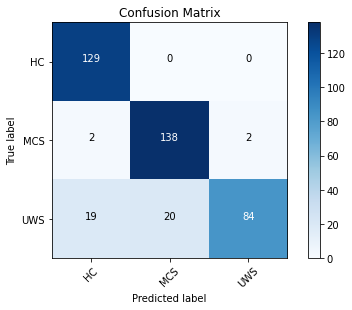

In [15]:
# ConditionB
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold3_Epoch19.pt")) # !!!!!!!!!!!!!!!!!!!!!
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold4_Epoch11.pt"))

# ConditionC
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold0_Epoch19.pt"))
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold1_Epoch28.pt"))
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold2_Epoch27.pt"))
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold3_Epoch50.pt"))
# 假设有模型的预测结果和真实标签
#例如，假设模型预测的结果存储在名为 predicted_labels 的张量中，
# 真实标签存储在名为 true_labels 的张量中
# predicted_labels = torch.tensor([0, 1, 2, 1, 0, 2])
# true_labels = torch.tensor([0, 1, 2, 1, 0, 1])

# 将张量转换为 NumPy 数组
predict_labels = predict_labels.cpu().numpy()
true_labels = true_labels.cpu().numpy()

# 计算混淆矩阵
conf_matrix = confusion_matrix(true_labels, predict_labels)

# 绘制混淆矩阵
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()

# 标记轴和标签
classes = ['HC', 'MCS', 'UWS']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# 添加数值标签
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


In [10]:
del predict_labels
del true_labels
gc.collect()
torch.cuda.empty_cache()

In [34]:
import random
hc = torch.zeros([1231,1])
mcs = torch.zeros([1353,1])
uws = torch.zeros([1220,1])
# test dataset
# 生成随机种子
torch.manual_seed(32)
# 生成随机索引
hc_indices = torch.randperm(len(hc))
mcs_indices = torch.randperm(len(mcs))
uws_indices = torch.randperm(len(uws))
test_percentage = 0.1
test_end = int(test_percentage * len(hc))
test_hc_indices = hc_indices[:test_end]
test_end = int(test_percentage * len(mcs))
test_mcs_indices = mcs_indices[:test_end]
test_end = int(test_percentage * len(uws))
test_uws_indices = uws_indices[:test_end]
print(test_hc_indices)
print(test_mcs_indices)
print(test_uws_indices)

tensor([ 565,  234, 1112,  173,  194,  389,  455,  114, 1133,  160,  380,  452,
         774,   86,  473,    2, 1191, 1152,   62,  354,  313,  619,  793,  487,
         936,  217,  226,  271,  443,   55, 1159,  408,  753,  350,  284,  680,
         535, 1045, 1172,  439,  874,  734,  168,  768,  661,  386,  777,  858,
        1043,  857,  645,   29, 1033,  610,  190,  495,  986,  841,  449,   32,
        1218,  362, 1103,  108,  738,   38,  567,  534, 1020,  884,  180, 1186,
          48,  721,  907,  254,  464,  555,  531, 1151,  704,  425,  163,  918,
         556,  537, 1091,  961,  929, 1134,  878,  581,  909,  149,  317,  905,
         352,  188,  401,  323, 1138,  393, 1058,  356,  112,  144,  300,  891,
         722,  990, 1014,  795,  447, 1198, 1062,  337, 1197,  673,  546,   14,
         959,   44,  713])
tensor([1230,  753, 1259,  797,  294,  721,  651, 1088,  883,  503, 1143,  220,
        1191,  129,  572, 1180,  619, 1215,  233,  210,  639,  575,  385,  499,
        1321,